In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import sys
sys.path.append('../../')

titanic_df = pd.read_csv('titanic_data/data.csv')
titanic_df['Survived'] = titanic_df['Survived'].map({0: 'Died', 1: 'Survived'})

In [2]:
import tabularmagic as tm
analyzer = tm.Analyzer(titanic_df, test_size=0.2, name='titanic')
analyzer

INFO: Analyzer initialized for dataset 'titanic'. Shapes of train, test DataFrames: 
      (712, 12), (179, 12). 


titanic 
----------------------------------------------------------------------------------------
Train shape: (712, 12)                      Test shape: (179, 12)                       
----------------------------------------------------------------------------------------
Categorical variables:
  'Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked' 
                                                                                        
Numeric variables:
  'PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare' 

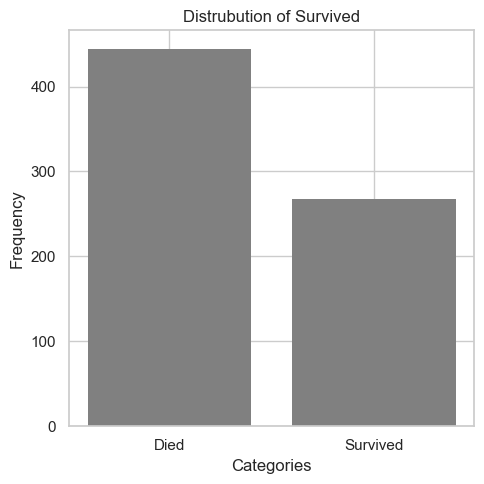

In [3]:
analyzer.eda().plot_distribution('Survived')

In [4]:
analyzer.load_data_checkpoint()
analyzer.impute(numeric_strategy='5nn').scale()

report = analyzer.classify(
    models=[
        tm.ml.LinearC('no_penalty'),
        tm.ml.LinearC('l1'),
        tm.ml.LinearC('l2'),
        tm.ml.TreesC('xgboost', n_trials=10)
    ],
    target='Survived',
    feature_selectors=[
        tm.fs.BorutaFSC()
    ]
)

INFO: Working DataFrames reset to original DataFrames. Shapes of train, test DataFrames: 
      (712, 12), (179, 12). 
INFO: Imputed missing values with strategy '5nn' for numeric variables 'PassengerId', 
      'Pclass', 'Age', 'SibSp', 'Parch', 'Fare' and strategy 'most_frequent' for 
      categorical variables 'Survived', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked' 
INFO: Scaled variables 'PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare' using 
      strategy 'standardize'. 
PROG: Fitting 'BorutaFSC'. 
INFO: Evaluating model 'LinearC(no_penalty)'. 
PROG: Fitting 'LinearC(no_penalty)'. Search method: GridSearchCV (1 fits per fold, 5 
      total fits).  
PROG: Optimal threshold set for LinearC(no_penalty) via F1 score. 
INFO: Successfully evaluated model 'LinearC(no_penalty)'. 
INFO: Evaluating model 'LinearC(l1)'. 
PROG: Fitting 'LinearC(l1)'. Search method: OptunaSearchCV (100 trials, 500 total fits). 
       
PROG: Optimal threshold set for LinearC(l1) via F1 score. 
INFO

In [5]:
report

ML Regression Report
----------------------------------------------------------------------------------------
Target variable:
  'Survived' 
                                                                                        
Predictor variables:
  'PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 
  'Cabin', 'Embarked' 
                                                                                        
Models evaluated:
  'LinearC(no_penalty)', 'LinearC(l1)', 'LinearC(l2)', 'TreesC(xgboost)' 
                                                                                        
Feature selectors:
  'BorutaFSC' 
----------------------------------------------------------------------------------------
Best models:
  1. 'LinearC(no_penalty)'                   Test AUROC: 0.8713 
  2. 'LinearC(l1)'                           Test AUROC: 0.87117 
  3. 'LinearC(l2)'                           Test AUROC: 0.86499 

In [9]:
report.metrics('test')

,LinearC(no_penalty),LinearC(l1),LinearC(l2),TreesC(random_forest)
Statistic,,,,
accuracy,0.810056,0.810056,0.804469,0.837989
f1,0.795181,0.795181,0.782609,0.797203
precision,0.717391,0.717391,0.724138,0.826087
recall,0.891892,0.891892,0.851351,0.77027
roc_auc,0.87426,0.873745,0.874003,0.871943
n_obs,179,179,179,179


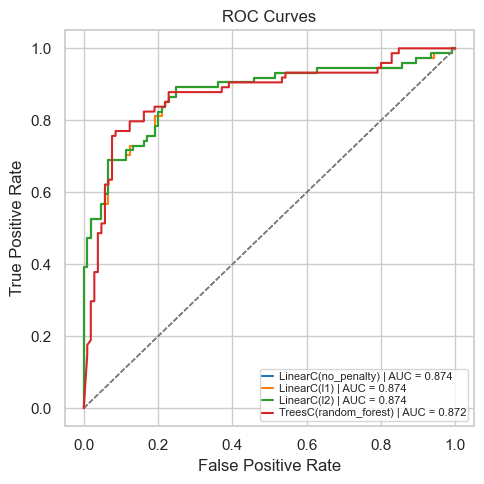

In [11]:
report.plot_roc_curves('test')

In [7]:
report.plot_confusion_matrix('LinearC(l1)')
print(report.model('LinearC(l1)').pos_label())

Survived


In [8]:
report.feature_importance('LinearC(no_penalty)')

,Coefficients
Feature,
male_yn(Sex),-2.575895
Pclass,-0.862971
Fare,0.050718
Age,-0.379166


In [9]:
report.feature_importance('TreeEnsembleC(random_forest)')

,Importances
Feature,
male_yn(Sex),0.343803
Pclass,0.124502
Fare,0.268053
Age,0.263642


In [3]:
glm_report = analyzer.glm(
    'binomial',
    target='Survived',
    predictors=[
        'Pclass',
        'Sex',
        'Fare',
        'Age'
    ]
)

WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Test data: dropped 37 rows with missing values out of a total of 179 rows. 


WARN: Train data: dropped 140 rows with missing values out of a total of 712 rows. 
WARN: Test data: dropped 37 rows with missing values out of a total of 179 rows. 


In [4]:
glm_report.statsmodels_summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Survived   No. Observations:                  572
Model:                            GLM   Df Residuals:                      567
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -267.21
Date:                Mon, 05 Aug 2024   Deviance:                       534.42
Time:                        21:05:40   Pearson chi2:                     595.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3404
Covariance Type:                  HC3                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.3005      0.602     -7.147      0.000      -5.480      -3.121
male_yn(Sex)     2.4775      0.220     11.276      0.000       2.047       2.908
Pclass           1.0853      0.174      6.234      0.000       0.744       1.427
Fare            -0.0010      0.002     -0.502      0.616      -0.005       0.003
Age              0.0276      0.009      3.182      0.001       0.011       0.045
================================================================================
"""